# Imports and downloads

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Important! Insert the path to the folder in which the models' parameters are saved
models_path = '/content/drive/MyDrive/Deep Learning Course/project_207028614_313472417'

lab_dir = os.path.join(models_path, "Recordings_22.5", "Lab_webm")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "Ronen_webm")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

In [3]:
# on sarah's pc only
models_path = r'C:\Users\97254\Documents\msc\Deep Learning\Project'

lab_dir = os.path.join(models_path, "Recordings_22.5", "Lab_webm")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "Ronen_webm")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('Running on CUDA')
else:
    print('Running on CPU')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Running on CPU


# Data Loader & Preprocessing

In [50]:
# Helpful Functions
from PIL import Image

def plot_labels(train_labels, test_labels):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the training set labels in blue
    ax.scatter(train_labels['x'], train_labels['y'], train_labels['z'], color='b', alpha=0.5, label='Train')

    # Plot the test set labels in red
    ax.scatter(test_labels['x'], test_labels['y'], test_labels['z'], color='r', alpha=0.5, label='Test')

    # Set the labels of the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the title of the plot
    ax.set_title('Label Distribution')

    # Add a legend
    ax.legend()

    plt.show()

def display_random_frame(dataset):
    # Get a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the videos and label at this index
    lab_video, ronen_video, label = dataset[idx]

    # Get the first frame of each video
    lab_frame = lab_video[0]
    ronen_frame = ronen_video[0]

    # Display the frames
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame)
    axs[0].set_title('Lab Frame')

    axs[1].imshow(ronen_frame)
    axs[1].set_title('Ronen Frame')

    
    #show color channels
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame, cmap='gray')
    axs[0].set_title('Lab Frame grayscale')

    axs[1].imshow(ronen_frame, cmap='gray')
    axs[1].set_title('Ronen Frame grayscale')


    #show color channels
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame[:, :, 0], cmap='gray')
    axs[0].set_title('Lab Frame - 0 channel')
    axs[0].axis('off')
    
    axs[1].imshow(ronen_frame[:, :, 0], cmap='gray')
    axs[1].set_title('Ronen Frame - 0 channel')
    axs[1].axis('off')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame[:, :, 1], cmap='gray')
    axs[0].set_title('Lab Frame - 1 channel')
    axs[0].axis('off')

    axs[1].imshow(ronen_frame[:, :, 1], cmap='gray')
    axs[1].set_title('Ronen Frame - 1 channel')
    axs[1].axis('off')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(lab_frame[:, :, 2], cmap='gray')
    axs[0].set_title('Lab Frame - 2 channel')
    axs[0].axis('off')

    axs[1].imshow(ronen_frame[:, :, 2], cmap='gray')
    axs[1].set_title('Ronen Frame - 2 channel')
    axs[1].axis('off')


    plt.show()

    print(ronen_frame.shape)
    

## Synchronization by Audio

In [ ]:
import moviepy.editor as mpy
ronen = ronen_dir+"/2023-05-23_08-14-44_1.webm"
# Load the video file
video = mpy.VideoFileClip(ronen)

# Get the audio frame rate
audio_frame_rate = video.audio.fps

print(f"The audio frame rate of ronen is {audio_frame_rate} Hz.")

###
lab = lab_dir+"/test1_2023-05-23_09-11-08_1.webm"

# Load the video file
video = mpy.VideoFileClip(lab)

# Get the audio frame rate
audio_frame_rate = video.audio.fps
print(f"The audio frame rate of the lab is {audio_frame_rate} Hz.")

The audio frame rate of ronen is 44100 Hz.
The audio frame rate of the lab is 44100 Hz.


In [6]:
import numpy as np
import moviepy.editor as mpy
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

SAMPLE_RATE = 44100

def load_video_and_extract_audio(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    video = mpy.VideoFileClip(file_path)
    audio = video.audio.to_soundarray(fps=SAMPLE_RATE)
    return video, audio

def convert_to_mono(audio):
    if audio.ndim == 2:
        return np.mean(audio, axis=1)
    return audio

def calculate_cross_correlation(audio1, audio2):
    return np.correlate(audio1, audio2, "full")

def find_offset(cross_correlation, audio_length):
    return cross_correlation.argmax() - (audio_length - 1)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_num_sample(filename):
  num_sample = filename.rsplit('_', 1)[1]
  num_sample = num_sample.split('.', 1)[0]
  return num_sample

def get_sorted_files(directory):
    # Get a sorted list of files in the directory based on sample number
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return sorted(files, key=lambda x: int(get_num_sample(x)))

ModuleNotFoundError: No module named 'moviepy'

In [ ]:
lab_files = get_sorted_files(lab_dir)
ronen_files = get_sorted_files(ronen_dir)

for lab_f, ronen_f in zip(lab_files, ronen_files):
        sample_num = get_num_sample(lab_f)
        ronen_sample_num = get_num_sample(ronen_f)
        print("Syncing video number: " + sample_num)
        if ronen_sample_num == sample_num:
            ronen = os.path.join(ronen_dir, ronen_f)
            lab = os.path.join(lab_dir, lab_f)

            # Define the frequency range for bird noises
            lowcut = 1000.0
            highcut = 2500.0

            # Load the videos and extract the audio
            ronen_video, ronen_audio = load_video_and_extract_audio(ronen)
            lab_video, lab_audio = load_video_and_extract_audio(lab)

            # Convert to mono
            ronen_audio = convert_to_mono(ronen_audio)
            lab_audio = convert_to_mono(lab_audio)

            # Normalize the audio
            ronen_audio = ronen_audio / np.max(np.abs(ronen_audio))
            lab_audio = lab_audio / np.max(np.abs(lab_audio))

            # Apply the bandpass filter
            ronen_audio = butter_bandpass_filter(ronen_audio, lowcut, highcut, SAMPLE_RATE, order=6)
            lab_audio = butter_bandpass_filter(lab_audio, lowcut, highcut, SAMPLE_RATE, order=6)

            cross_correlation = calculate_cross_correlation(ronen_audio, lab_audio)

            offset = find_offset(cross_correlation, len(ronen_audio))
            if offset > 0:
              offset_seconds = offset / SAMPLE_RATE
              lab_video = lab_video.set_start(offset_seconds, change_end=False)
              ronen_video = ronen_video.set_end(lab_video.duration)
              print('cutting Lab video')
            elif offset < 0:
              offset = -offset
              offset_seconds = offset / SAMPLE_RATE
              ronen_video = ronen_video.set_start(offset_seconds, change_end=False)
              lab_video = lab_video.set_end(ronen_video.duration)
              print('cutting Ronen video')
            else:
              print('no offset')

            lab_video.write_videofile(models_path+"/Recordings_22.5/lab_synced/lab_sync_video_"+str(sample_num)+".webm")
            ronen_video.write_videofile(models_path+"/Recordings_22.5/ronen_synced/ronen_sync_video_"+str(sample_num)+".webm")

        else:
            print(f"No matching file found for sample number {sample_num} in 'ronen_dir'. Skipping...")


In [ ]:
sample_num = 28
#cross_correlation = calculate_cross_correlation(lab_audio, ronen_audio) #moving the second signal on top of the first
cross_correlation = calculate_cross_correlation(ronen_audio, lab_audio)

offset = find_offset(cross_correlation, len(ronen_audio))
if offset >= 0:
  offset_seconds = offset / SAMPLE_RATE
  lab_video = lab_video.set_start(offset_seconds, change_end=False)
  ronen_video = ronen_video.set_end(lab_video.duration)
  print('cutting Lab video')
else:
  offset = -offset
  offset_seconds = offset / SAMPLE_RATE
  ronen_video = ronen_video.set_start(offset_seconds, change_end=False)
  lab_video = lab_video.set_end(ronen_video.duration)
  print('cutting Ronen video')

lab_video.write_videofile(models_path+"/Recordings_22.5/lab_sync_vid/lab_sync_video"+str(sample_num)+".webm")
ronen_video.write_videofile(models_path+"/Recordings_22.5/ronen_sync_vid/ronen_sync_video"+str(sample_num)+".webm")

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,

  return stacker(self.iter_chunks(fps=fps, quantize=quantize,



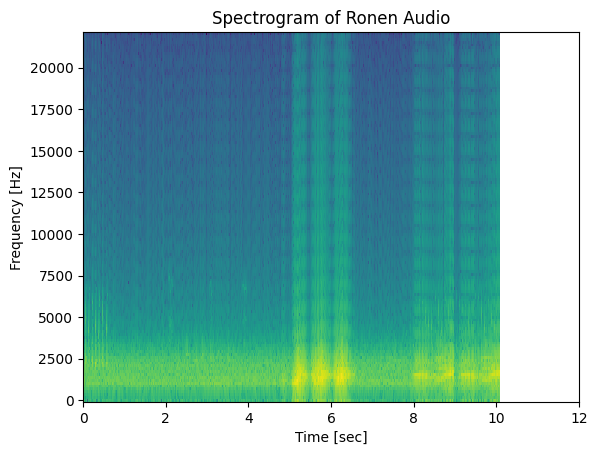

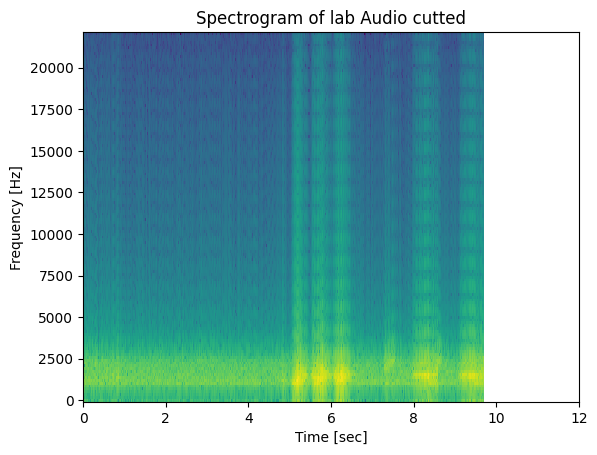

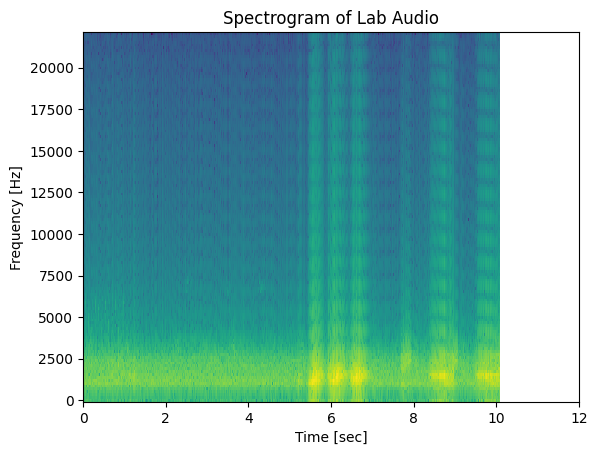

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_spectrogram(audio, fs, title):
    f, t, Sxx = spectrogram(audio, fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, 12])
    plt.title(title)
    plt.show()


# Define the frequency range for bird noises
lowcut = 1000.0
highcut = 2500.0

# Load the videos and extract the audio
ronen_video, ronen_audio = load_video_and_extract_audio(ronen)
lab_video, lab_audio = load_video_and_extract_audio(lab)

# Convert to mono
ronen_audio = convert_to_mono(ronen_audio)
lab_audio_cut = convert_to_mono(lab_audio_cut)
lab_audio = convert_to_mono(lab_audio)

# Normalize the audio
ronen_audio = ronen_audio / np.max(np.abs(ronen_audio))
lab_audio_cut = lab_audio_cut / np.max(np.abs(lab_audio_cut))
lab_audio = lab_audio / np.max(np.abs(lab_audio))

# Apply the bandpass filter
ronen_audio = butter_bandpass_filter(ronen_audio, lowcut, highcut, SAMPLE_RATE, order=6)
lab_audio_cut = butter_bandpass_filter(lab_audio_cut, lowcut, highcut, SAMPLE_RATE, order=6)
lab_audio = butter_bandpass_filter(lab_audio, lowcut, highcut, SAMPLE_RATE, order=6)

# Plot the spectrograms
plot_spectrogram(ronen_audio, SAMPLE_RATE, 'Spectrogram of Ronen Audio')
plot_spectrogram(lab_audio_cut, SAMPLE_RATE, 'Spectrogram of lab Audio cutted')
plot_spectrogram(lab_audio, SAMPLE_RATE, 'Spectrogram of Lab Audio')

# Continue with the rest of your code...


## Data Loader

In [93]:
class VideoDataset(Dataset):
    def __init__(self, lab_dir, ronen_dir, labels_csv):
        self.lab_files = sorted(os.listdir(lab_dir))
        self.ronen_files = sorted(os.listdir(ronen_dir))
        self.lab_dir = lab_dir
        self.ronen_dir = ronen_dir

        # Load the labels from the CSV file
        self.labels = pd.read_excel(labels_csv, usecols=range(4)).set_index('filename')
        # Convert the labels to floats
        self.labels = self.labels.astype(float)

    def __len__(self):
        return len(self.lab_files)

    def __getitem__(self, idx):
        lab_file = self.lab_files[idx]
        ronen_file = self.ronen_files[idx]

        # Check that the files are correctly synchronized
        assert lab_file.split('_')[-1] == ronen_file.split('_')[-1], \
            f"Files are not synchronized: {lab_file}, {ronen_file}"

        # Load the videos using OpenCV
        lab_video = self.load_and_crop_video(os.path.join(self.lab_dir, lab_file))
        ronen_video = self.load_and_crop_video(os.path.join(self.ronen_dir, ronen_file))

        # Get the label for this video
        label = self.labels.loc[ronen_file, ['x', 'y', 'z']].values

        # Print out the label array
        print(f"Label for {ronen_file}: {label}")

        label = torch.tensor(label, dtype=torch.float)

        return lab_video, ronen_video, label

    def train_test_split_videos(self, test_size=0.2, random_state=None):
        # Discretize the labels into bins
        bins = pd.cut(self.labels['x'], bins=10)

        # Generate a sequence of indices from 0 to len(self) - 1
        indices = list(range(len(self)))

        # Split the indices into training indices and test indices
        train_indices, test_indices = train_test_split(
            indices, test_size=test_size, stratify=bins, random_state=random_state)

        # Create two new datasets: one for training and one for testing
        train_dataset = torch.utils.data.Subset(self, train_indices)
        test_dataset = torch.utils.data.Subset(self, test_indices)

        return train_dataset, test_dataset

    def load_and_crop_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []

        # Define the crop area (top, left, bottom, right)
        top, left, bottom, right = 0, 0, 285, 385

        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret:
                # Convert the frame from BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Crop the frame
                frame = frame[top:bottom, left:right]
                # Detect and draw circles
                frames.append(frame)
            else:
                break

        cap.release()

        # Convert the list of frames to a single numpy array
        frames = np.array(frames)

        # Convert the numpy array to a 4D tensor
        video = torch.from_numpy(frames)

        return video
        
        

In [17]:
lab_dir = os.path.join(models_path, "Recordings_22.5", "lab_synced")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "ronen_synced")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

# Instantiate the dataset
dataset = VideoDataset(lab_dir, ronen_dir, labels_csv)
# Split the dataset into a training set and a test set
train_dataset, test_dataset = dataset.train_test_split_videos(test_size=0.2, random_state=42)

# Instantiate the data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

Label for ronen_sync_video_104.webm: [ 1. -1.  0.]


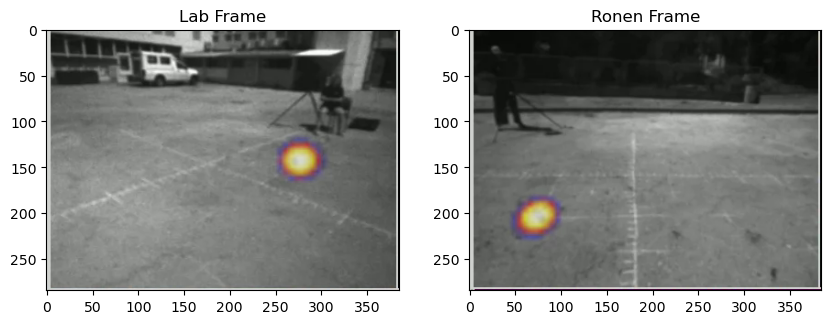

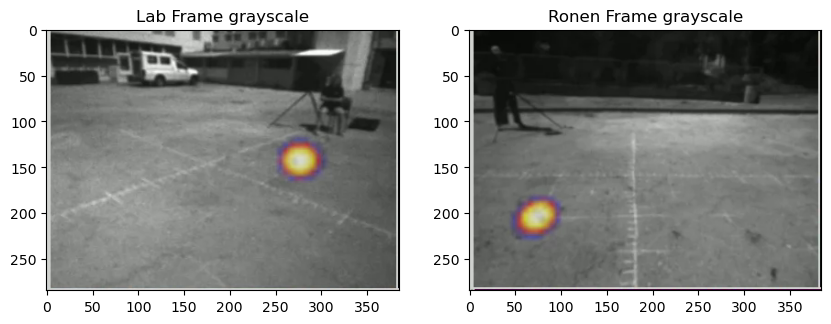

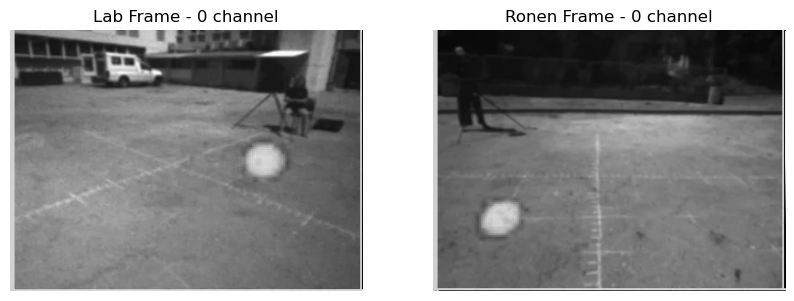

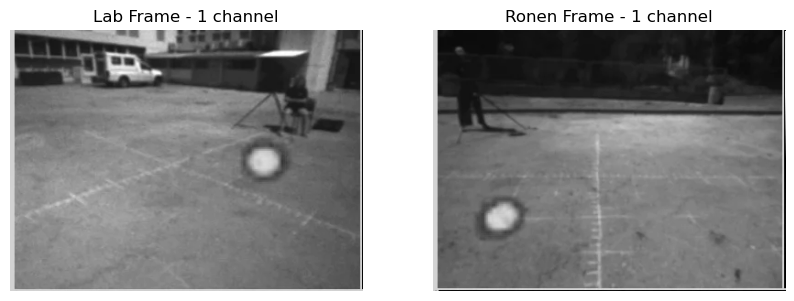

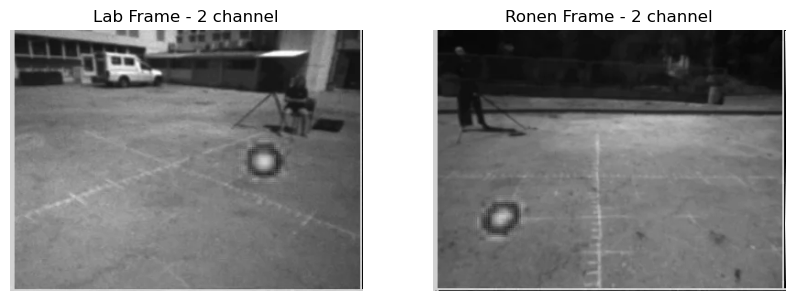

torch.Size([285, 385, 3])


In [98]:
# Display a random frame from the dataset
display_random_frame(dataset)

In [ ]:
ab_dir = os.path.join(models_path, "Recordings_22.5", "lab_synced")
ronen_dir = os.path.join(models_path, "Recordings_22.5", "ronen_synced")
labels_csv = os.path.join(models_path, "Recordings_22.5", "labels.xlsx")

# Create dataset
dataset = VideoDataset(lab_dir, ronen_dir, labels_csv)

# Fetch a video
lab_video, ronen_video, label = dataset[0]  # replace 0 with the index of the video you want

# Convert tensor to numpy array
ronen_video = ronen_video.numpy()
lab_video = lab_video.numpy()

# Specify red threshold
red_threshold = 1.005

# Initialize list to hold frames with red objects
frames_with_red_objects = []

# Loop through frames
for i in range(min(len(ronen_video), len(lab_video))):
    ronen_frame, lab_frame = ronen_video[i], lab_video[i]
    # Split into RGB channels
    r_ronen, g_ronen, b_ronen = cv2.split(ronen_frame)
    r_lab, g_lab, b_lab = cv2.split(lab_frame)

    # If the maximum intensity in the red channel exceeds the threshold, save the frame
    if (np.mean(r_ronen)/np.mean(b_ronen) > red_threshold) and (np.mean(r_lab)/np.mean(b_lab) > red_threshold):
        frames_with_red_objects.append((i, ronen_frame, lab_frame))


# Display frames with red objects
for i, ronen_frame, lab_frame in frames_with_red_objects:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(ronen_frame)
    axs[0].set_title(f'Frame {i+1} ronen')

    axs[1].imshow(lab_frame)
    axs[1].set_title(f'Frame {i+1} lab')

    plt.show()


#percentage of frames with red objects
print(f"Percentage of frames with red objects: {len(frames_with_red_objects)/len(ronen_video)*100}%")


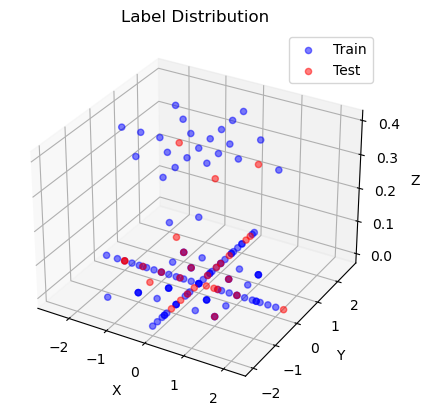

In [19]:
# Get the labels for the training set and the test set
train_labels = dataset.labels.iloc[train_dataset.indices]
test_labels = dataset.labels.iloc[test_dataset.indices]

# Plot the distributions of the labels in the training set and the test set
plot_labels(train_labels, test_labels)

In [20]:
import random
# Size of data
# [num_frames, x, y, num_color_channels]

# Get a random index
idx = random.randint(0, len(dataset) - 1)

# Get the videos and label at this index
lab_video, ronen_video, label = dataset[idx]

# Get the size of each frame (matrix) for the lab video
lab_frame_size = lab_video[0].shape

# Get the size of each frame (matrix) for the ronen video
ronen_frame_size = ronen_video[0].shape

# Get the size of the entire set of frames (video) for the lab video
lab_video_size = lab_video.shape

# Get the size of the entire set of frames (video) for the ronen video
ronen_video_size = ronen_video.shape

print(f"Size of each frame in lab video: {lab_frame_size}")
print(f"Size of lab video frames at index {idx}: {lab_video_size}")

print(f"\nSize of each frame in ronen video: {ronen_frame_size}")
print(f"Size of ronen video frames at index {idx}: {ronen_video_size}")

# [num_frames, x, y, num_color_channels]

Label for ronen_sync_video_35.webm: [0.  0.4 0. ]
Size of each frame in lab video: torch.Size([285, 385, 3])
Size of lab video frames at index 70: torch.Size([245, 285, 385, 3])

Size of each frame in ronen video: torch.Size([285, 385, 3])
Size of ronen video frames at index 70: torch.Size([245, 285, 385, 3])


## Frame selection

In [72]:
# Functions

# find circles in a frame
# input: frame
# output: circles
# circles: [x, y, r]
def find_circles(frame, dp=1.5, mindist=20):
    # convert to gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # blur
    gray = cv2.medianBlur(gray, 5)
    # find circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, dp, mindist)
    # convert to int
    if circles is not None:
        circles = np.uint16(np.around(circles))
    else:
        circles = []
    print(len(circles))
    return circles


In [80]:
path = r"C:\Users\97254\Documents\msc\Deep Learning\Project\Recordings_22.5\ronen_synced\ronen_sync_video_1.webm"

cap = cv2.VideoCapture(path)
frames = []

# Define the crop area (top, left, bottom, right)
top, left, bottom, right = 0, 0, 285, 385

circles_list = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        # Convert the frame from BGR to RGB and blur it
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.medianBlur(frame, 5)
        print(frame.shape)
        print(type(frame))
        # find circles in the frame
        circles = cv2.HoughCircles(frame, cv2.HOUGH_GRADIENT, 1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)

        if circles is not None:
            circles = np.uint16(np.around(circles))

            for i in circles[0, :]:
                # Draw the outer circle
                cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)

                # Draw the center of the circle
                cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)

            # Display the image
            plt.imshow(frame, cmap='gray')
    plt.show()

cap.release()

# print sum of circles in each frame
for i in range(len(circles_list)):
    print(f"frame {i}: {len(circles_list[i])}")

# Convert the list of frames to a single numpy array
frames = np.array(frames)

# Convert the numpy array to a 4D tensor
video = torch.from_numpy(frames)



(454, 670, 3)
<class 'numpy.ndarray'>


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:2257: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'cv::HoughCircles'


In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the video file
video_path = r"C:\Users\97254\Documents\msc\Deep Learning\Project\Recordings_22.5\ronen_synced\ronen_sync_video_1.webm"

# Try to open the video
try:
    # Load the video
    cap = cv2.VideoCapture(video_path)
    
    # If the video is not opened, raise an error
    if not cap.isOpened():
        raise IOError("Unable to open '{}'".format(video_path))

except IOError as e:
    print(e)
    exit(-1)

while(cap.isOpened()):
    # Read the frame
    ret, frame = cap.read()

    if ret:
        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply median blur to the frame
        gray = cv2.medianBlur(gray, 5)

        # Apply Hough Transform to detect circles
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=20,
                                   param1=50, param2=30, minRadius=0, maxRadius=0)

        # If at least 1 circle is detected
        if circles is not None:
            circles = np.uint16(np.around(circles))

            for i in circles[0, :]:
                # Draw the outer circle
                cv2.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)

                # Draw the center of the circle
                cv2.circle(frame, (i[0], i[1]), 2, (0, 0, 255), 3)

            # Display the frame
            cv2.imshow('Video', frame)
            
            # Break the loop on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


# Models

model taken from: https://github.com/pranoyr/cnn-lstm/blob/master/models/cnnlstm.py

In [133]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torchvision.models import resnet18, resnet101

In [153]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=600, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
       
    def forward(self, x_3d1, x_3d2):
        batch_size, timesteps, C, H, W = x_3d1.size()
        c_in = x_3d1.view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)

        batch_size, timesteps, C, H, W = x_3d2.size()
        c_in = x_3d2.view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)
        r_in2 = c_out.view(batch_size, timesteps, -1)

        r_in = torch.cat((r_in, r_in2), 2)

        out, _ = self.lstm(r_in)
        print('shape of out: ', out.shape)
        x = self.fc1(out[:, -1, :])  # get the last output
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Train

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM(num_classes=3).to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (video1, video2, labels) in enumerate(trainloader):
        video1, video2 = video1.permute(0, 1, 4, 2, 3), video2.permute(0, 1, 4, 2, 3)
        video1 = video1.float().to(device)
        video2 = video2.float().to(device)
        labels = labels.to(device)
        
        outputs = model(video1, video2)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

c:\Users\97254\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\97254\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Label for ronen_sync_video_24.webm: [-0.4  0.   0. ]


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 883224576 bytes.